# Name: Anthony Gillioz 

# Assignment 2 ATML 2019
## CIFAR-10 classification with limited data
CIFAR-10 is a dataset with 10 image classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). https://www.cs.toronto.edu/~kriz/cifar.html  
We'll be working on a subset of the dataset (10k images, 1k per class, 32x32 pixels, RGB) and train a model to classify an image into one of the 10 classes.  
You may want to plot some images to get a better understanding what the data looks like (not credited).  
Loading data is implemented:  

In [2]:
from datasets import CIFAR10Limited
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter, RandomAffine

# Basic transforms - you may need to change them
transforms = {'train': Compose([RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(1.0, 1.2), shear=5),
                                RandomHorizontalFlip(),
                                ColorJitter(0.2, 0.4),
                                ToTensor(),
                                Normalize(mean=(0.5, 0.5, 0.5),
                                          std=(0.5, 0.5, 0.5))]),
               'val': Compose([ToTensor(),
                              Normalize(mean=(0.5, 0.5, 0.5),
                                        std=(0.5, 0.5, 0.5))])}


train_dataset = CIFAR10Limited('cifar_data', split='train', transform=transforms['train'], download=True)
val_dataset = CIFAR10Limited('cifar_data', split='val', transform=transforms['val'], download=True)
test_dataset = CIFAR10Limited('cifar_data', split='test', transform=transforms['val'], download=True)

0it [00:00, ?it/s]

100%|█████████▉| 170139648/170498071 [00:35<00:00, 7687819.69it/s]

Files already downloaded and verified
Files already downloaded and verified


# Train a multilayer perceptron model (MLP) 

## 1. Train a model from MLPModel class, without any regularization. Use ADAM optimizer with default parameters to train for 25 epochs; optimize cross entropy loss. Note final accuracy and validation loss. Is the model overfitting? Why? 

In [0]:
import torch.nn as nn
    
class MLPModel(nn.Module):
    
    def __init__(self):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(nn.Linear(32*32*3, 128),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(128, 10))
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [0]:
# Import module
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

from itertools import product
from torch.utils.data import DataLoader
from train_tools import TrainHelper

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
params = {'batch_size': 64,
          'shuffle': True}

train_loader = DataLoader(train_dataset, **params)
val_loader = DataLoader(val_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

In [0]:
def plot_graph(nb_epochs, train, val, step):
    plt.figure()
    plt.plot(np.arange(nb_epochs), train)
    plt.plot(np.arange(nb_epochs), val)
    plt.legend(['training', 'validation'])
    plt.xlabel('epoch')
    plt.ylabel(f'{step} value')
    plt.title(f'Train/val {step}');
        
    plt.show()

In [0]:
def plot_stats(stats_training):
    train_loss, val_loss, train_acc, val_acc, nb_epochs = stats_training
    plot_graph(nb_epochs, train_loss, val_loss, "Loss")
    plot_graph(nb_epochs, train_acc, val_acc, "Accuracy")

Train_loss: 1.459 |                Val_loss: 1.574 |                Train_acc: 49.090 |                Val_acc: 45.220


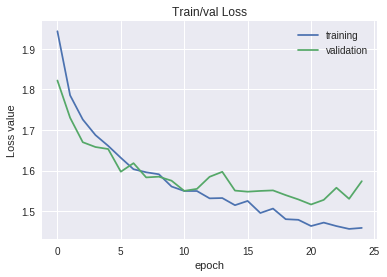

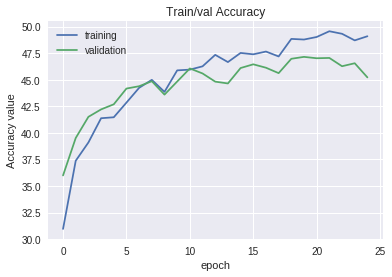

In [8]:
nb_epochs = 25
trainer = TrainHelper(nb_epochs=nb_epochs, device=device)

neural_net = MLPModel()
neural_net.to(device)

optimizer = torch.optim.Adam(neural_net.parameters())
loss_function = nn.CrossEntropyLoss()
    
stats_training = trainer.fit(neural_net,
                             train_loader,
                             val_loader,
                             optimizer,
                             loss_function)
plot_stats(stats_training)

MLPModel(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 2. Improve the model to get at least 46.5% accuracy on validation set in at most 25 epochs of training.
### For example: you can tweak the parameters (e.g. learning rate, batch size), the model (e.g. number of layers, number of units, activation function), add regularization (e.g. data augmentation, dropout, weight decay, early stopping).
### Note all the parameters and results on validation set for at least 4 settings that you tried (including the best one)
### You can get extra points for accuracy above 46.5%.

In [0]:
class DynamicMLPModel(nn.Module):
    
    _input_size = 32*32*3
    _output_size = 10
    
    def __init__(self, nb_layers, nb_nodes, drop_rate, l_slop):
        super(DynamicMLPModel, self).__init__()
        
        layers = [nn.Linear(self._input_size, nb_nodes)]
        
        for _ in range(nb_layers):
            layers.append(nn.Linear(nb_nodes, nb_nodes))
            layers.append(nn.Dropout(drop_rate))
            layers.append(nn.LeakyReLU(l_slop))
            
        layers.append(nn.Linear(nb_nodes, self._output_size))
            
        self.layers = nn.Sequential(*layers)
        
    
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return self.layers(input)

In [0]:
def get_optim_params(w_decay, l_rate, param_opti):
    optimizer_parameters = {"weight_decay": w_decay,
                            "lr": l_rate}
    
    if param_opti:
        optimizer_parameters['momentum'] = param_opti
        
    return optimizer_parameters

In [0]:
def print_parameters(chromosome, hyperparameters):
    print("".join([f" {name}: {float(val)} "
                   for name, val in zip(hyperparameters.keys(), chromosome)]))

 lr: 1e-05  dropout: 0.25  weight_decay: 5e-05  nb_layers: 14.0  nb_nodes: 512.0  l_slop: 0.01  batch_size: 128.0  optimizer: 1.0 
Train_loss: 2.302 |                Val_loss: 2.303 |                Train_acc: 10.270 |                Val_acc: 9.630





Best 9.629999999999999


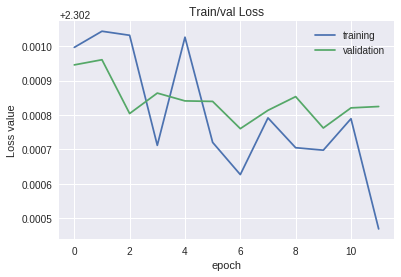

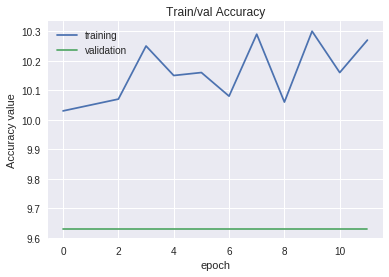

 lr: 1e-05  dropout: 0.05  weight_decay: 0.0001  nb_layers: 18.0  nb_nodes: 256.0  l_slop: 0.01  batch_size: 64.0  optimizer: 1.0 
Train_loss: 2.302 |                Val_loss: 2.303 |                Train_acc: 9.970 |                Val_acc: 10.210





Best 10.209999999999999


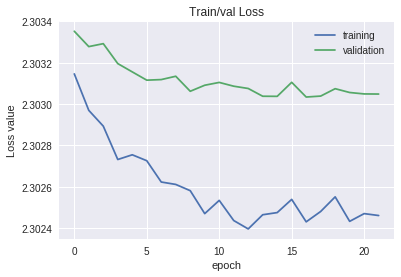

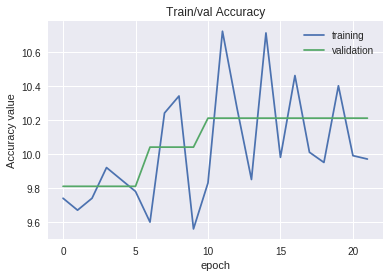

 lr: 0.0005  dropout: 0.5  weight_decay: 0.0005  nb_layers: 7.0  nb_nodes: 16.0  l_slop: 0.1  batch_size: 256.0  optimizer: 0.0 
Train_loss: 2.109 |                Val_loss: 2.065 |                Train_acc: 18.050 |                Val_acc: 19.740





Best 19.74


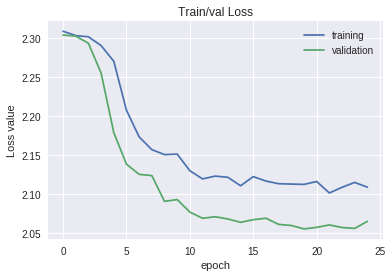

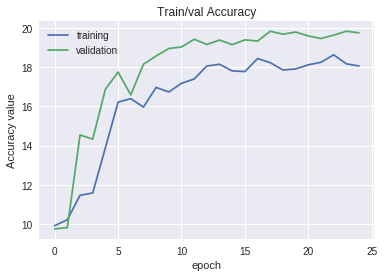

 lr: 0.0005  dropout: 0.05  weight_decay: 0.0001  nb_layers: 9.0  nb_nodes: 256.0  l_slop: 0.001  batch_size: 512.0  optimizer: 1.0 
Train_loss: 1.805 |                Val_loss: 1.798 |                Train_acc: 30.110 |                Val_acc: 31.070





Best 31.069999999999997


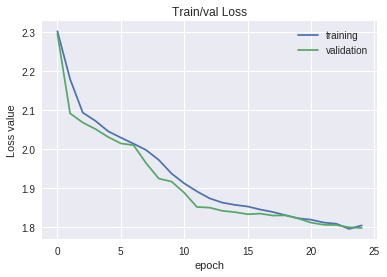

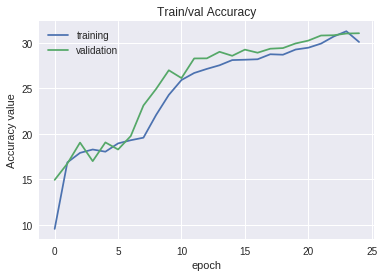

 lr: 0.001  dropout: 0.05  weight_decay: 0.0001  nb_layers: 14.0  nb_nodes: 4.0  l_slop: 0.0001  batch_size: 128.0  optimizer: 1.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 9.990 |                Val_acc: 10.240


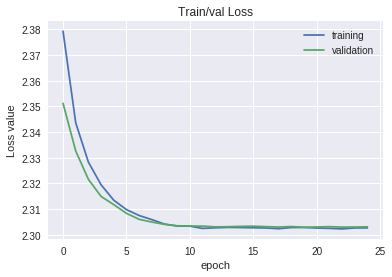

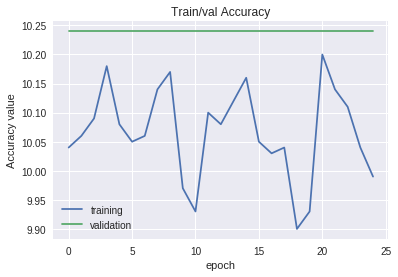

 lr: 5e-05  dropout: 0.30000000000000004  weight_decay: 1e-05  nb_layers: 14.0  nb_nodes: 512.0  l_slop: 0.1  batch_size: 256.0  optimizer: 1.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 10.230 |                Val_acc: 10.210


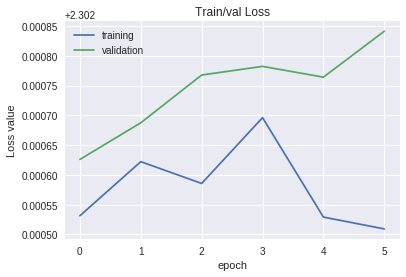

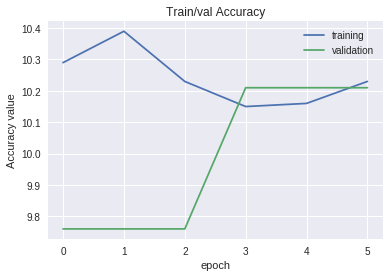

 lr: 1e-05  dropout: 0.1  weight_decay: 1e-05  nb_layers: 7.0  nb_nodes: 8.0  l_slop: 0.01  batch_size: 64.0  optimizer: 1.0 
Train_loss: 2.317 |                Val_loss: 2.315 |                Train_acc: 9.680 |                Val_acc: 9.810


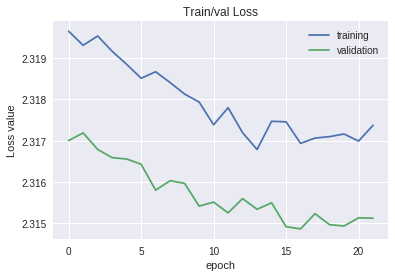

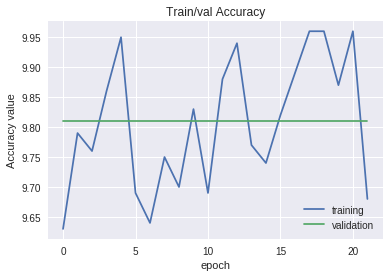

 lr: 1e-05  dropout: 0.1  weight_decay: 0.0001  nb_layers: 16.0  nb_nodes: 512.0  l_slop: 0.0001  batch_size: 64.0  optimizer: 0.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 9.680 |                Val_acc: 10.210


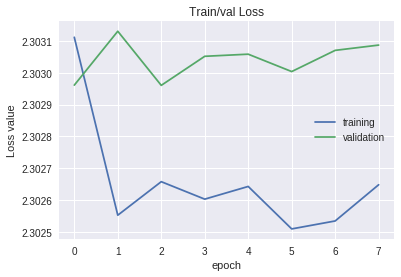

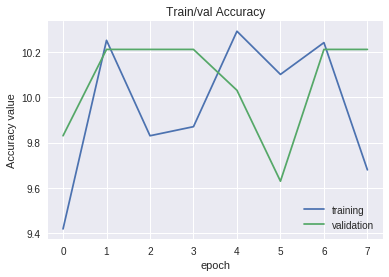

 lr: 0.001  dropout: 0.30000000000000004  weight_decay: 0.0001  nb_layers: 17.0  nb_nodes: 32.0  l_slop: 0.0001  batch_size: 512.0  optimizer: 0.0 
Train_loss: 2.302 |                Val_loss: 2.303 |                Train_acc: 10.220 |                Val_acc: 9.830


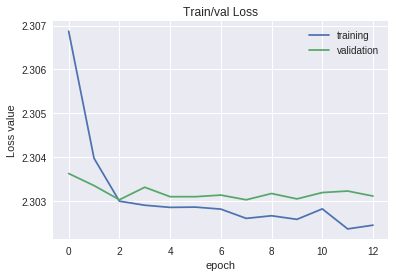

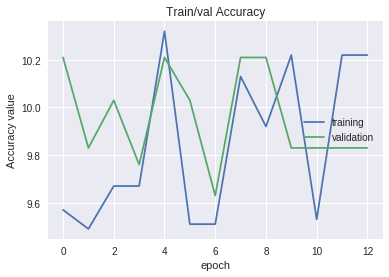

 lr: 5e-05  dropout: 0.25  weight_decay: 0.0005  nb_layers: 19.0  nb_nodes: 256.0  l_slop: 0.01  batch_size: 64.0  optimizer: 0.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 10.140 |                Val_acc: 10.210


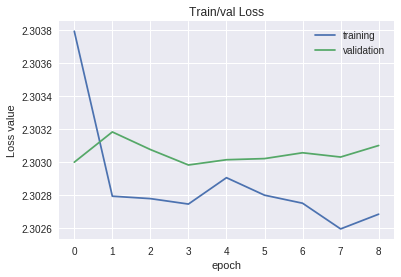

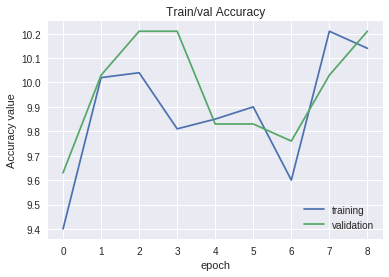

 lr: 0.0001  dropout: 0.0  weight_decay: 1e-05  nb_layers: 12.0  nb_nodes: 256.0  l_slop: 0.1  batch_size: 32.0  optimizer: 0.0 
Train_loss: 1.706 |                Val_loss: 1.718 |                Train_acc: 36.740 |                Val_acc: 37.040





Best 37.04


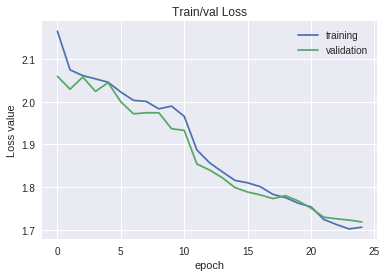

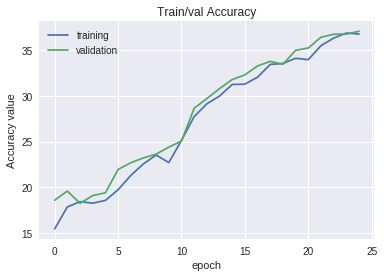

 lr: 0.005  dropout: 0.15000000000000002  weight_decay: 0.0005  nb_layers: 9.0  nb_nodes: 64.0  l_slop: 0.1  batch_size: 128.0  optimizer: 1.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 9.660 |                Val_acc: 9.830


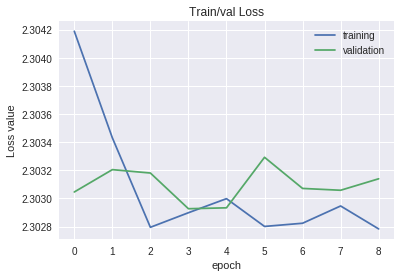

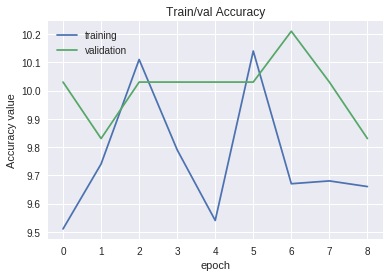

 lr: 0.0005  dropout: 0.1  weight_decay: 1e-05  nb_layers: 2.0  nb_nodes: 16.0  l_slop: 0.01  batch_size: 32.0  optimizer: 1.0 
Train_loss: 1.787 |                Val_loss: 1.705 |                Train_acc: 35.120 |                Val_acc: 38.630





Best 38.629999999999995


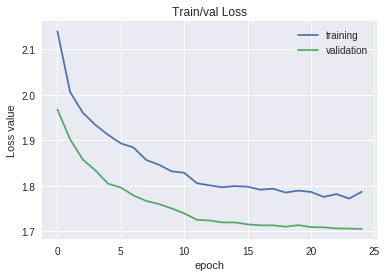

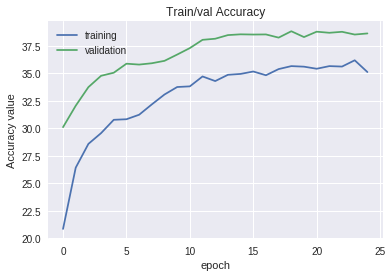

 lr: 0.0005  dropout: 0.0  weight_decay: 0.0005  nb_layers: 12.0  nb_nodes: 256.0  l_slop: 0.1  batch_size: 512.0  optimizer: 1.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 10.140 |                Val_acc: 9.630


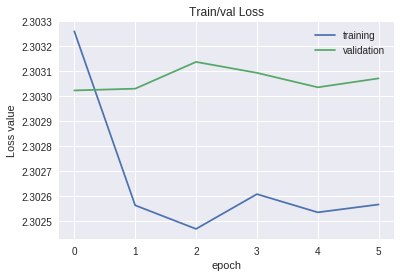

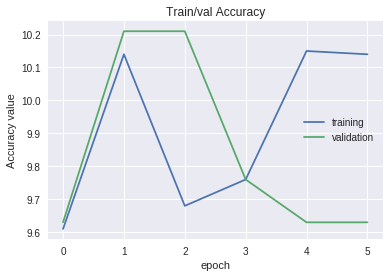

 lr: 1e-05  dropout: 0.25  weight_decay: 1e-05  nb_layers: 10.0  nb_nodes: 512.0  l_slop: 0.1  batch_size: 128.0  optimizer: 0.0 
Train_loss: 1.959 |                Val_loss: 1.947 |                Train_acc: 20.520 |                Val_acc: 21.170


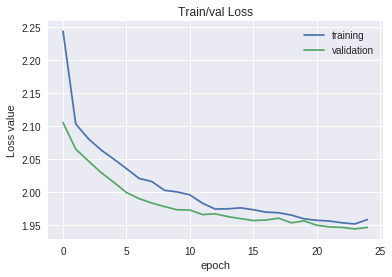

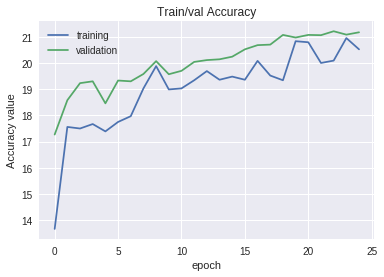

 lr: 0.0005  dropout: 0.30000000000000004  weight_decay: 1e-05  nb_layers: 17.0  nb_nodes: 128.0  l_slop: 0.1  batch_size: 16.0  optimizer: 1.0 
Train_loss: 2.302 |                Val_loss: 2.303 |                Train_acc: 10.030 |                Val_acc: 9.760


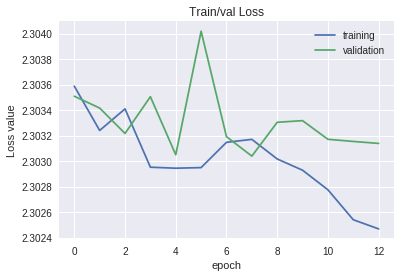

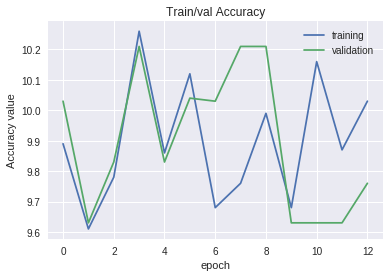

 lr: 0.0005  dropout: 0.1  weight_decay: 1e-05  nb_layers: 3.0  nb_nodes: 4.0  l_slop: 0.0001  batch_size: 128.0  optimizer: 1.0 
Train_loss: 2.097 |                Val_loss: 2.032 |                Train_acc: 20.730 |                Val_acc: 24.470


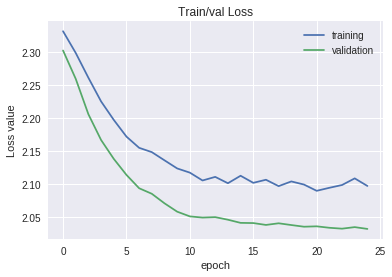

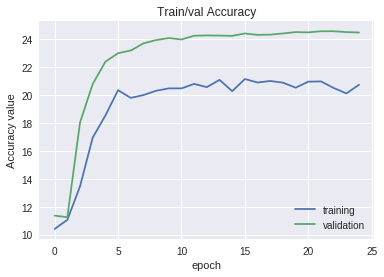

 lr: 0.0005  dropout: 0.1  weight_decay: 5e-05  nb_layers: 8.0  nb_nodes: 32.0  l_slop: 0.0001  batch_size: 128.0  optimizer: 1.0 
Train_loss: 1.996 |                Val_loss: 1.969 |                Train_acc: 21.520 |                Val_acc: 23.740


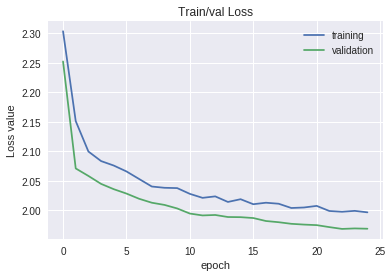

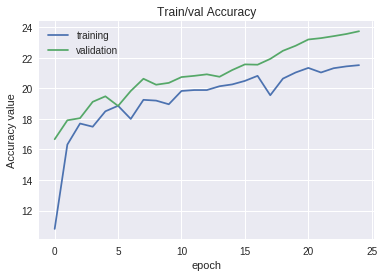

 lr: 0.0005  dropout: 0.05  weight_decay: 5e-05  nb_layers: 15.0  nb_nodes: 128.0  l_slop: 0.1  batch_size: 16.0  optimizer: 0.0 
Train_loss: 5.331 |                Val_loss: 2.678 |                Train_acc: 10.960 |                Val_acc: 9.380


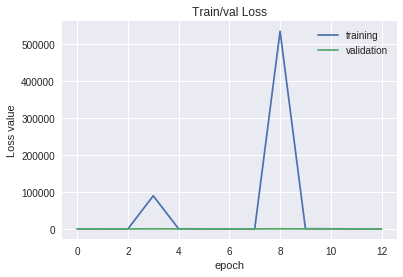

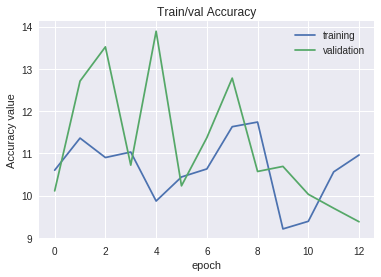

 lr: 5e-05  dropout: 0.05  weight_decay: 0.0001  nb_layers: 9.0  nb_nodes: 128.0  l_slop: 0.0001  batch_size: 128.0  optimizer: 0.0 
Train_loss: 1.911 |                Val_loss: 1.912 |                Train_acc: 23.960 |                Val_acc: 23.070


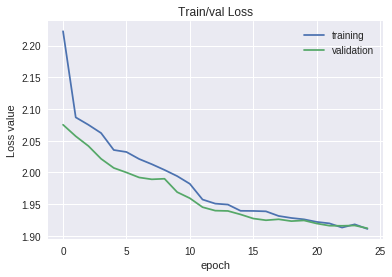

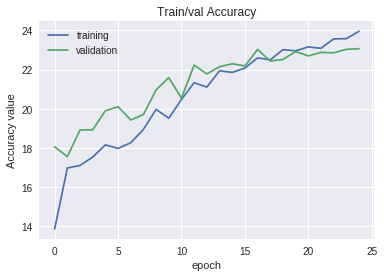

 lr: 0.005  dropout: 0.2  weight_decay: 0.0001  nb_layers: 11.0  nb_nodes: 128.0  l_slop: 0.01  batch_size: 64.0  optimizer: 0.0 
Train_loss: 1020855987623.949 |                Val_loss: 276036610765.452 |                Train_acc: 10.800 |                Val_acc: 9.830


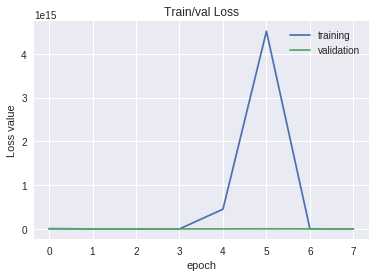

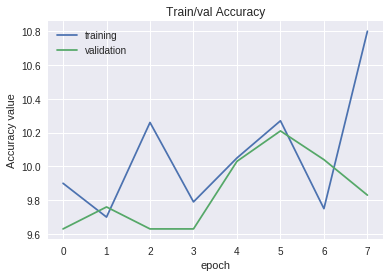

 lr: 0.001  dropout: 0.15000000000000002  weight_decay: 0.0005  nb_layers: 15.0  nb_nodes: 8.0  l_slop: 0.0001  batch_size: 512.0  optimizer: 1.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 10.980 |                Val_acc: 9.630


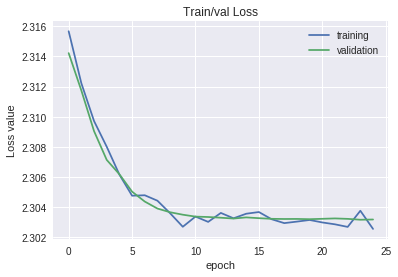

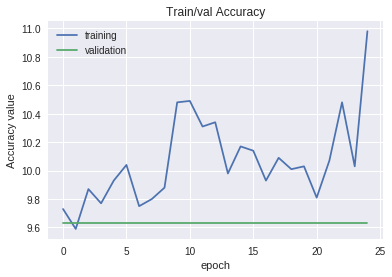

 lr: 5e-05  dropout: 0.5  weight_decay: 0.0005  nb_layers: 20.0  nb_nodes: 32.0  l_slop: 0.0001  batch_size: 256.0  optimizer: 1.0 
Train_loss: 2.308 |                Val_loss: 2.305 |                Train_acc: 10.350 |                Val_acc: 9.630


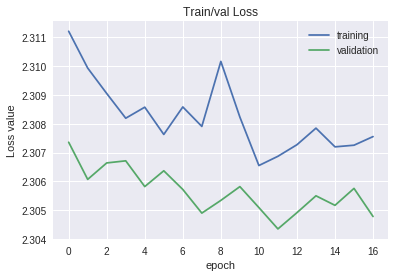

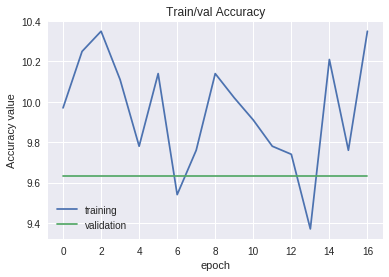

 lr: 0.0005  dropout: 0.4  weight_decay: 5e-05  nb_layers: 6.0  nb_nodes: 128.0  l_slop: 0.01  batch_size: 512.0  optimizer: 1.0 
Train_loss: 1.930 |                Val_loss: 1.859 |                Train_acc: 26.790 |                Val_acc: 29.330


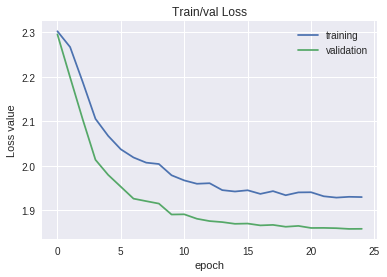

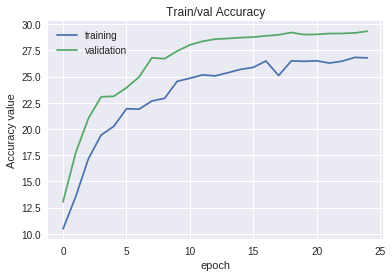

 lr: 0.001  dropout: 0.30000000000000004  weight_decay: 0.0001  nb_layers: 11.0  nb_nodes: 4.0  l_slop: 0.1  batch_size: 16.0  optimizer: 1.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 10.570 |                Val_acc: 9.830


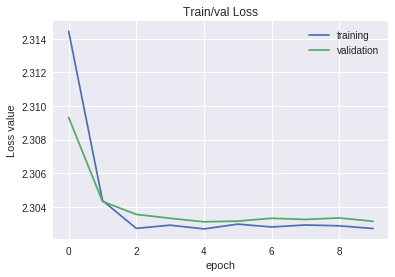

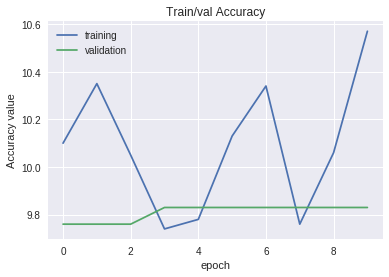

 lr: 0.0001  dropout: 0.35000000000000003  weight_decay: 1e-05  nb_layers: 12.0  nb_nodes: 4.0  l_slop: 0.01  batch_size: 32.0  optimizer: 1.0 
Train_loss: 2.309 |                Val_loss: 2.308 |                Train_acc: 10.270 |                Val_acc: 10.040


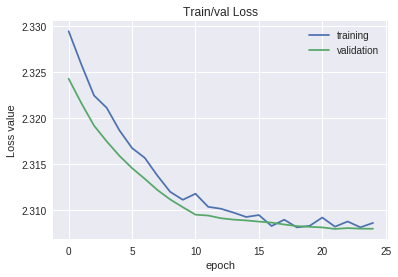

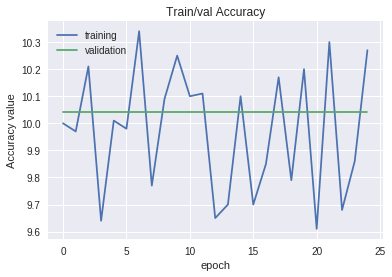

 lr: 5e-05  dropout: 0.4  weight_decay: 0.0005  nb_layers: 6.0  nb_nodes: 8.0  l_slop: 0.001  batch_size: 32.0  optimizer: 0.0 
Train_loss: 2.172 |                Val_loss: 2.101 |                Train_acc: 16.690 |                Val_acc: 19.510


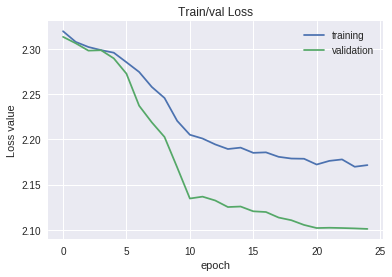

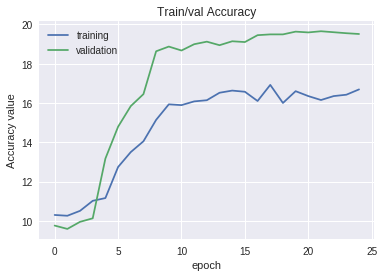

 lr: 0.0005  dropout: 0.4  weight_decay: 0.0005  nb_layers: 4.0  nb_nodes: 4.0  l_slop: 0.0001  batch_size: 256.0  optimizer: 1.0 
Train_loss: 2.270 |                Val_loss: 2.237 |                Train_acc: 12.100 |                Val_acc: 15.390


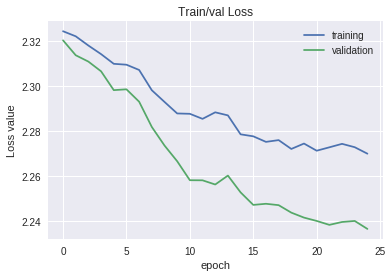

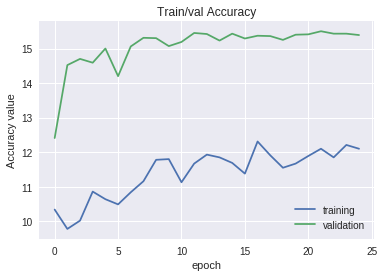

 lr: 0.001  dropout: 0.05  weight_decay: 5e-05  nb_layers: 5.0  nb_nodes: 32.0  l_slop: 0.001  batch_size: 16.0  optimizer: 0.0 
Train_loss: 2.184 |                Val_loss: 2.090 |                Train_acc: 16.460 |                Val_acc: 18.540


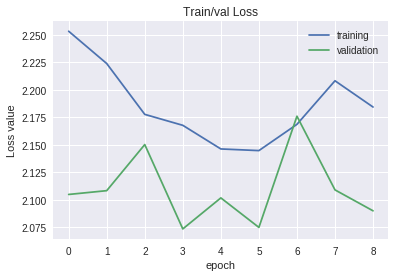

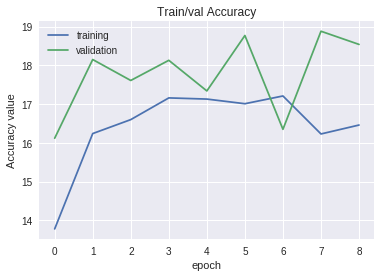

 lr: 0.0001  dropout: 0.0  weight_decay: 1e-05  nb_layers: 19.0  nb_nodes: 32.0  l_slop: 0.001  batch_size: 128.0  optimizer: 0.0 
Train_loss: 2.303 |                Val_loss: 2.303 |                Train_acc: 9.980 |                Val_acc: 10.210


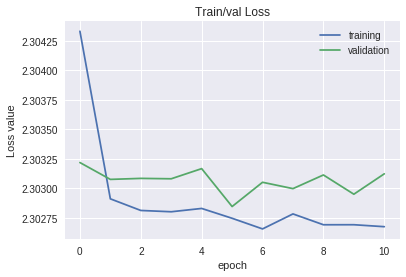

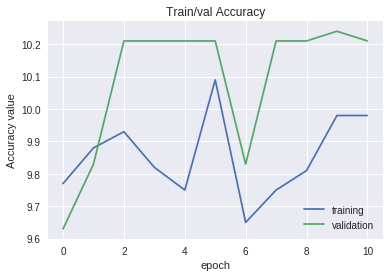

NameError: ignored

In [65]:
from copy import deepcopy
from GA import GeneticAlgorithm
nb_epochs = 25
trainer = TrainHelper(nb_epochs=nb_epochs, device=device)

optimizers = [(torch.optim.RMSprop, 0.9), (torch.optim.Adam, None)]

hyperparameters = {"lr": [10**-i*j for i, j in product(range(3, 6), [1, 5])],
                   "dropout": np.arange(0.0, 0.55, .05),
                   "weight_decay": [10**-i*j
                                    for i, j in product(range(4, 6), [1, 5])],
                   "nb_layers": list(range(2, 21)),
                   "nb_nodes": [2**i for i in range(1, 11)],
                   "l_slop": [10**-i for i in range(1, 5)],
                   "batch_size": [2**i for i in range(4, 10)],
                   "optimizer": list(range(len(optimizers)))}

GA = GeneticAlgorithm(hyperparameters, 30)
population = GA.init_population()
counter_generation = 0

# best parameters: (validation acc, drop_rate, statistic of the training)
best_parameters = (float("-INF"), )

# keep a copy of the best trained network
best_model = None

debug = True

loss_function = nn.CrossEntropyLoss()

run = True

accuracies = np.zeros((GA.population_size, ))

while run:
    for i, chromosome in enumerate(population):
        l_rate, drop_rate, w_decay, nb_layers, nb_nodes, l_slop,batch_size, optimizer = chromosome
        
        params = {'batch_size': int(batch_size),
                  'shuffle': True}

        train_loader = DataLoader(train_dataset, **params)
        val_loader = DataLoader(val_dataset, **params)
        
        
        dynamic_nn = DynamicMLPModel(int(nb_layers), int(nb_nodes), drop_rate, l_slop)
        dynamic_nn.to(device)
        
        func, param_opti = optimizers[int(optimizer)]
        
        optimizer_parameters = get_optim_params(w_decay,
                                                l_rate,
                                                param_opti)
        
        dynamic_optimizer = func(dynamic_nn.parameters(),
                                **optimizer_parameters)
    
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=dynamic_optimizer,
                                                    step_size=10,
                                                    gamma=0.2)
        
        print_parameters(chromosome, hyperparameters)
        stats_training = trainer.fit(dynamic_nn,
                                     train_loader,
                                     val_loader,
                                     dynamic_optimizer,
                                     loss_function,
                                     scheduler=scheduler)
        
        acc_val = stats_training[3][-1]
        if acc_val > best_parameters[0]:
            best_parameters = (acc_val,
                               chromosome[:],
                               stats_training)
            best_model = deepcopy(dynamic_nn)
            print("="*30)
            print("\n"*4)
            print(f"Best {acc_val}")
            print("="*30)
            
        accuracies[i] = acc_val
        
        if debug:
            plot_stats(stats_training)
        
        if counter_generation >= 100:
            run = False
        
    counter_generation += 1
    population = GA.next_population(accuracies)
    
    print("================Next Generation")
    
print(best_parameters)

In [29]:
from copy import deepcopy
nb_epochs = 25
trainer = TrainHelper(nb_epochs=nb_epochs, device=device)

hyperparameters = {"drop_rate": [0.0, 0.1, 0.15],
                   "lr": [0.00005, 0.0005], 
                   "weight_decay": [0.00005, 0.0001], 
                   "optimizer": [(torch.optim.RMSprop, 0.9), (torch.optim.Adam, None)]
                   }

# best parameters: (validation acc, drop_rate, statistic of the training)
best_parameters = (float("-INF"), None, None, None, None, None)

# keep a copy of the best trained network
best_model = None

debug = False

loss_function = nn.CrossEntropyLoss()

for drop_rate, l_rate, w_decay, opt_func in product(*hyperparameters.values()):
    improved_neural_net = ImprovedMLPModel(10, drop_rate)
    improved_neural_net.to(device)
    
    func, parameter = opt_func
    
    optimizer_parameters = {"weight_decay": w_decay,
                            "lr": l_rate}
    
    if parameter:
        optimizer_parameters['momentum'] = parameter

    improved_optimizer = func(improved_neural_net.parameters(),
                              **optimizer_parameters)
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=improved_optimizer,
                                                step_size=10,
                                                gamma=0.2) 
    
    
    print(f'Dropout rate: {drop_rate}, Learning rate {l_rate}, Weight decay {w_decay}, optimizer {func.__name__}')
    stats_training = trainer.fit(improved_neural_net,
                                 train_loader,
                                 val_loader,
                                 improved_optimizer,
                                 loss_function,
                                 scheduler=scheduler)
    
    if stats_training[3][-1] > best_parameters[0]:
        best_parameters = (stats_training[3][-1], drop_rate, l_rate, w_decay, func, stats_training)
        best_model = deepcopy(improved_neural_net)
    
    if debug:
        plot_stats(stats_training)
        

best_acc, best_drop_rate, best_l_rate, best_w_decay, best_optimizer, best_stats = best_parameters

print(f'\n\nBest parameters: {best_drop_rate} dropout rate, {best_l_rate} learning rate\
, {best_w_decay} weight decay, {best_optimizer.__name__}  optimizer and validation accuracies: {best_acc:.2f}%')

plot_stats(best_stats)

Dropout rate: 0.0, Learning rate 5e-05, Weight decay 5e-05, optimizer RMSprop
Train_loss: 2.302 |                Val_loss: 2.303 |                Train_acc: 10.140 |                Val_acc: 9.630
Dropout rate: 0.0, Learning rate 5e-05, Weight decay 5e-05, optimizer Adam


KeyboardInterrupt: ignored

# Train a convolutional neural network

## 3. Implement a convolutional neural network according to the definition below:
- Convolutional layer, filter size 5x5, stride 1, 64 filters
- Activation function Leaky ReLU, slope 0.2
- Max Pooling layer, pooling size 2x2, stride 2
- Convolutional layer, filter size 5x5, stride 1, 64 filters
- Activation function Leaky ReLU, slope 0.2
- Max Pooling layer, pooling size 2x2, stride 2
- Flatten the output into a vector
- Fully connected (linear) layer, 384 units
- Activation function Leaky ReLU, slope 0.2
- Dropout with dropout probability 0.5
- Fully connected (linear) layer, 192 units
- Activation function Leaky ReLU, slope 0.2
- Dropout with dropout probability 0.5
- Fully connected (linear) layer, 10 units

In [0]:
import torch.nn as nn
    
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO - define layers
        LReLU_slop = 0.2
        dropout_rate = 0.5
        
        self.conv_layers = nn.Sequential(
            # in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.Conv2d(3, 64, 5, stride=1, padding=0), # 64, 28, 28
            nn.LeakyReLU(0.2),
            torch.nn.MaxPool2d(2, stride=2, padding=0), # 64, 14, 14
            nn.Conv2d(64, 64, 5, stride=1, padding=0), # 64, 10, 10
            nn.LeakyReLU(0.2),
            torch.nn.MaxPool2d(2, stride=2, padding=0) # 64, 5, 5
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64*5*5, 384),
            nn.Dropout(dropout_rate),
            nn.LeakyReLU(0.2),
            nn.Linear(384, 192),
            nn.Dropout(dropout_rate),
            nn.LeakyReLU(0.2),
            nn.Linear(192, 10)
        )
    
    def forward(self, input_):
        # TODO - define forward pass
        input_ = self.conv_layers(input_)
        input_ = input_.view(input_.size(0), -1)
        out = self.fc_layers(input_)
        
        return out
        

## 4. Train the network you implemented
- train for 25 epochs
- optimize cross entropy loss
- use Adam optimizer with learning rate 0.001
- reduce learning rate by a factor of 10 after epoch 10 and after epoch 20
- use weight decay 0.004

You should be able to get around 67% accuracy on validation set. Report final training loss, training accuracy, validation loss and validation accuracy

Train_loss: 0.997 |                Val_loss: 0.981 |                Train_acc: 65.350 |                Val_acc: 65.050


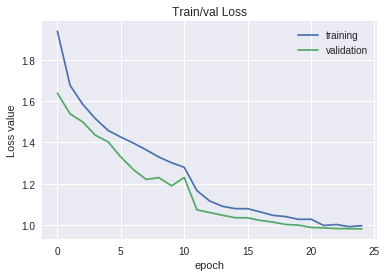

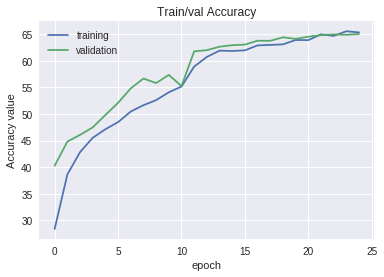

In [0]:
# Your code for training
nb_epochs = 25

cnn_trainer = TrainHelper(nb_epochs=nb_epochs, device=device)

cnn = ConvNet()
cnn.to(device)
cnn_optimizer = torch.optim.Adam(cnn.parameters(),
                                 lr=0.001,
                                 weight_decay=0.004)
cnn_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=cnn_optimizer,
                                                step_size=10,
                                                gamma=0.1) 
cnn_loss_function = nn.CrossEntropyLoss()


stats_training = trainer.fit(cnn,
                             train_loader,
                             val_loader,
                             cnn_optimizer,
                             cnn_loss_function,
                             scheduler=cnn_scheduler)

plot_stats(stats_training)

## 5. Evaluate on test set
Evaluate your best MLP model and your trained ConvNet model on the test set. Report the test accuracy on both models.

In [0]:
_, mlp_acc = cnn_trainer.validation(best_model, test_loader, cnn_loss_function)
_, cnn_acc = cnn_trainer.validation(cnn, test_loader, cnn_loss_function)

print(f'MLP accuracy: {mlp_acc:.2f}%, CNN accuracy: {cnn_acc}%')

MLP accuracy: 51.70%, CNN accuracy: 66.4%
